In [63]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectrum for a single protein complex.
    """
    mz_range = np.arange(1, 20001)
    spectrum = np.zeros_like(mz_range, dtype=float)

    MS = complex_mass
    MA = Q * MS**0.76
    ME = MS + MA
    ZA = 0.0467 * ME**0.533 + F
    TT = np.exp(-(np.arange(maxcharge) - 50)**2 / chargewidth)
    sumT = np.sum(TT)
    WC = np.zeros(maxcharge)
    DE = np.zeros_like(WC)

    for charge in range(maxcharge):
        WC[charge] = np.exp(-(charge + 1 - ZA)**2 / chargewidth) / sumT
        if ME > 0:
            DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * AO * VA
        else:
            DE[charge] = 0  # Set to 0 if ME is zero or negative

    WD = WC * DE

    for charge in range(1, maxcharge + 1):
        mz = ME / charge
        if mz < len(mz_range):
            lower_limit = max(1, int(mz - resolution / 10))
            upper_limit = min(len(mz_range), int(mz + resolution / 10))
            for axis in range(lower_limit, upper_limit):
                spread = np.exp(-((axis - mz)**2) / (2 * (resolution / 100)**2))
                spectrum[axis] += WD[charge - 1] * spread

    noise = np.random.normal(0, noise_level, size=spectrum.size)
    spectrum += noise

    return spectrum

def simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectra for two proteins and their complexes based on an interaction matrix.

    Parameters:
    - monomer_masses: list of float, masses of the two protein monomers in Da
    - interaction_matrix: 2D numpy array, where (0, 0) represents no proteins, (1, 0) represents Protein A monomer, (0, 1) represents Protein B monomer, and so on
    - resolution: float, resolution of the mass spectrometer
    - chargewidth: float, width of the charge distribution
    - maxcharge: int, maximum charge state to consider
    - noise_level: float, standard deviation of Gaussian noise added to the spectrum
    - Q: float, parameter for accounting for adduct binding
    - F: float, parameter for charge state fluctuation
    - AO: float, open area of the detector
    - VA: float, accelerating voltage

    Returns:
    - mz_range: array, m/z range of the spectrum
    - normalized_spectrum: array, combined intensity values across the m/z range for all proteins and complexes, normalized against the sum of intensities
    """
    mz_range = np.arange(1, 20001)
    combined_spectrum = np.zeros_like(mz_range, dtype=float)

    for i, j in np.argwhere(interaction_matrix):
        monomer_mass_A = monomer_masses[0]
        monomer_mass_B = monomer_masses[1]
        stoich_A = i  # Stoichiometry of Protein A
        stoich_B = j  # Stoichiometry of Protein B

        complex_mass = stoich_A * monomer_mass_A + stoich_B * monomer_mass_B  # Calculate the complex mass according to equation S1
        spectrum = simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
        combined_spectrum += spectrum * interaction_matrix[i, j]  # Scale by the interaction matrix value

    # Normalize the combined spectrum against the sum of intensities
    total_intensity = np.sum(combined_spectrum)
    if total_intensity > 0:
        normalized_spectrum = combined_spectrum / total_intensity
    else:
        normalized_spectrum = combined_spectrum

    return mz_range, normalized_spectrum

In [67]:
import pandas as pd
import numpy as np 

def create_interaction_matrix(n_proteins):
    """Creates a random interaction matrix for n_proteins
    and then randomises the values in the matrix between 0 and 1
    then takes all non-zero values and replaces them with a random number between 1 and 6"""

    interaction_matrix = np.zeros((n_proteins, n_proteins))
    interaction_matrix = np.random.randint(0, 2, (interaction_matrix.shape))
    interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
    print("your interaction matrix:", interaction_matrix)
    
    return interaction_matrix

def run_all_functions():
    """Runs all functions and returns the mz_range and normalized_spectrum"""
    interaction_matrix = create_interaction_matrix(6)
    monomer_masses = [210000, 18000]
    resolution = 1000
    chargewidth = 5
    maxcharge = 50
    noise_level = 0.000
    Q = 0.1
    F = 1
    AO = 1
    VA = 1

    mz_range, normalized_spectrum = simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
    return mz_range, normalized_spectrum


In [68]:
plt.figure(figsize=(10, 6))
plt.plot(*run_all_functions())

Your interaction matrix:
         1-mer_A  2-mer_A  3-mer_A  4-mer_A  5-mer_A  6-mer_A
1-mer_B      2.0      2.0      3.0      3.0      3.0      5.0
2-mer_B      5.0      4.0      1.0      5.0      6.0      1.0
3-mer_B      2.0      4.0      3.0      2.0      4.0      4.0
4-mer_B      3.0      6.0      4.0      3.0      3.0      3.0
5-mer_B      2.0      1.0      2.0      4.0      4.0      5.0
6-mer_B      2.0      5.0      2.0      1.0      5.0      1.0


KeyError: (0, 0)

<Figure size 1000x600 with 0 Axes>

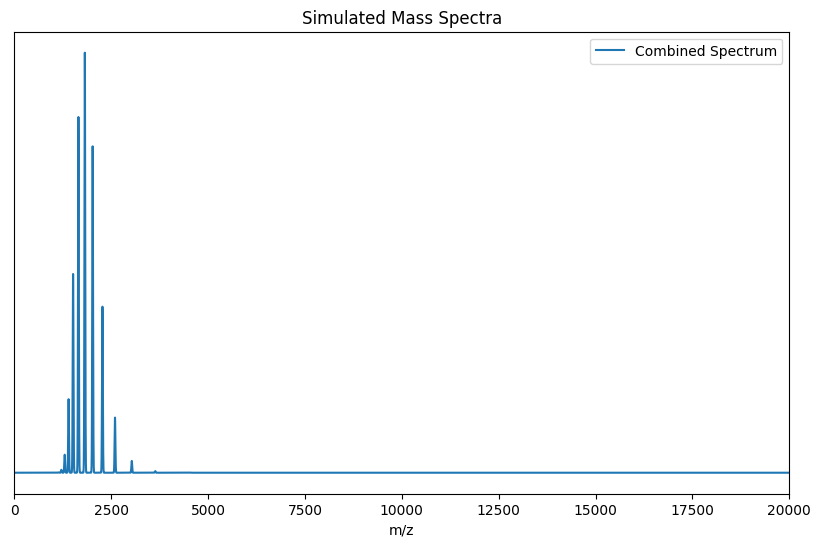

In [64]:
print(interaction_matrix)

[[2 0 0 0 0 3]
 [0 4 2 1 6 2]
 [5 2 5 6 0 6]
 [4 2 2 3 3 3]
 [6 1 5 0 1 4]
 [2 4 0 2 5 1]]


In [66]:
interaction_matrix[2,3]
interaction_matrix[1,1]

4

Your interaction matrix:
         1-mer_A  1-mer_B  2-mer_A  2-mer_B  3-mer_A  3-mer_B
4-mer_A        2        1        3        0        4        6
4-mer_B        5        0        0        3        6        1
5-mer_A        1        3        0        0        0        1
5-mer_B        0        3        6        1        0        0
6-mer_A        6        4        5        0        0        1
6-mer_B        0        2        0        1        1        4


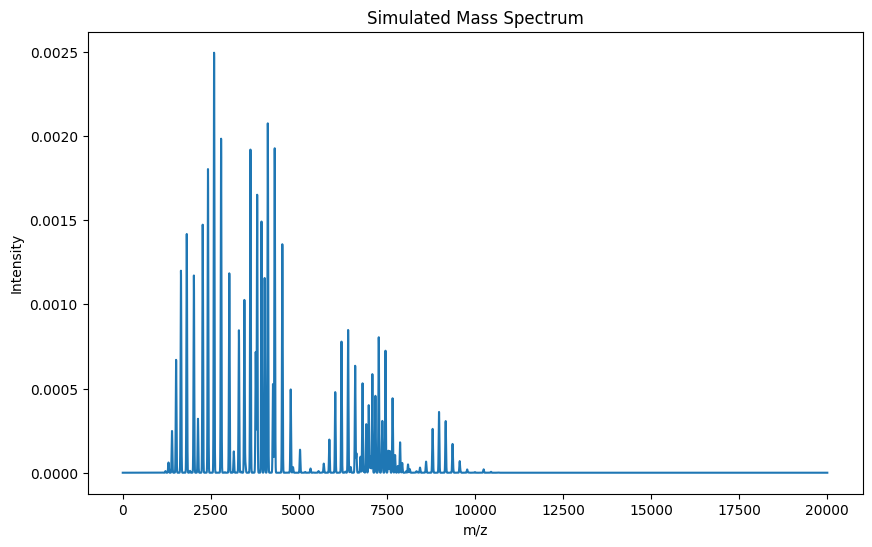

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectrum for a single protein complex.
    """
    mz_range = np.arange(1, 20001)
    spectrum = np.zeros_like(mz_range, dtype=float)

    MS = complex_mass
    MA = Q * MS**0.76
    ME = MS + MA
    ZA = 0.0467 * ME**0.533 + F
    TT = np.exp(-(np.arange(maxcharge) - 50)**2 / chargewidth)
    sumT = np.sum(TT)
    WC = np.zeros(maxcharge)
    DE = np.zeros_like(WC)

    for charge in range(maxcharge):
        WC[charge] = np.exp(-(charge + 1 - ZA)**2 / chargewidth) / sumT
        DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * AO * VA if ME > 0 else 0

    WD = WC * DE

    for charge in range(1, maxcharge + 1):
        mz = ME / charge
        if mz < len(mz_range):
            lower_limit = max(1, int(mz - resolution / 10))
            upper_limit = min(len(mz_range), int(mz + resolution / 10))
            for axis in range(lower_limit, upper_limit):
                spread = np.exp(-((axis - mz)**2) / (2 * (resolution / 100)**2))
                spectrum[axis] += WD[charge - 1] * spread

    noise = np.random.normal(0, noise_level, size=spectrum.size)
    spectrum += noise

    return spectrum


def simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectra for two proteins and their complexes based on an interaction matrix.

    Parameters:
    - monomer_masses: list of float, masses of the two protein monomers in Da
    - interaction_matrix: 2D numpy array, where (0, 0) represents no proteins, (1, 0) represents Protein A monomer, (0, 1) represents Protein B monomer, and so on
    - resolution: float, resolution of the mass spectrometer
    - chargewidth: float, width of the charge distribution
    - maxcharge: int, maximum charge state to consider
    - noise_level: float, standard deviation of Gaussian noise added to the spectrum
    - Q: float, parameter for accounting for adduct binding
    - F: float, parameter for charge state fluctuation
    - AO: float, open area of the detector
    - VA: float, accelerating voltage

    Returns:
    - mz_range: array, m/z range of the spectrum
    - normalized_spectrum: array, combined intensity values across the m/z range for all proteins and complexes, normalized against the sum of intensities
    """
    mz_range = np.arange(1, 20001)
    combined_spectrum = np.zeros_like(mz_range, dtype=float)

    for i, j in np.argwhere(interaction_matrix > 0):  # Only consider non-zero interactions
        monomer_mass_A = monomer_masses[0]
        monomer_mass_B = monomer_masses[1]
        stoich_A = i  # Stoichiometry of Protein A
        stoich_B = j  # Stoichiometry of Protein B

        complex_mass = stoich_A * monomer_mass_A + stoich_B * monomer_mass_B  # Calculate the complex mass according to equation S1
        spectrum = simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
        combined_spectrum += spectrum * interaction_matrix[i, j]  # Scale by the interaction matrix value

    # Normalize the combined spectrum against the sum of intensities
    total_intensity = np.sum(combined_spectrum)
    normalized_spectrum = combined_spectrum / total_intensity if total_intensity > 0 else combined_spectrum

    return mz_range, normalized_spectrum


def create_interaction_matrix(n_proteins):
    """
    Creates a random interaction matrix for n_proteins and then randomizes the values in the matrix between 0 and 1.
    Then takes all non-zero values and replaces them with a random number between 1 and 6.
    Returns the interaction matrix as a DataFrame.
    """
    interaction_matrix = np.random.randint(0, 2, (n_proteins, n_proteins))
    interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)

    # Convert the interaction matrix to a DataFrame with meaningful labels
    labels = [f"{i}-mer_{'A' if j == 0 else 'B'}" for i in range(1, n_proteins + 1) for j in range(2)]
    interaction_matrix_df = pd.DataFrame(interaction_matrix, columns=labels[:n_proteins], index=labels[n_proteins:])

    print("Your interaction matrix:")
    print(interaction_matrix_df)

    return interaction_matrix


def run_all_functions():
    """Runs all functions and returns the mz_range and normalized_spectrum"""
    interaction_matrix = create_interaction_matrix(6)
    monomer_masses = [210000, 18000]
    resolution = 1000
    chargewidth = 5
    maxcharge = 50
    noise_level = 0.000
    Q = 0.1
    F = 1
    AO = 1
    VA = 1

    mz_range, normalized_spectrum = simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
    return mz_range, normalized_spectrum


# Run the simulation and plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(*run_all_functions())
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Simulated Mass Spectrum')
plt.show()

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz, load_npz
import json

class NativeMassSpecSimulator:
    def __init__(self, monomer_masses, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
        self.monomer_masses = monomer_masses
        self.resolution = resolution
        self.chargewidth = chargewidth
        self.maxcharge = maxcharge
        self.noise_level = noise_level
        self.Q = Q
        self.F = F
        self.AO = AO
        self.VA = VA
        self.run_counter = 0  # Initialize run counter


    def simulate_complex_spectrum(self, complex_mass):

        mz_range = np.arange(1, 20001)
        spectrum = np.zeros_like(mz_range, dtype=float)

        MS = complex_mass
        MA = Q * MS**0.76
        ME = MS + MA
        ZA = 0.0467 * ME**0.533 + F
        TT = np.exp(-(np.arange(maxcharge) - 50)**2 / chargewidth)
        sumT = np.sum(TT)
        WC = np.zeros(maxcharge)
        DE = np.zeros_like(WC)

        for charge in range(maxcharge):
            WC[charge] = np.exp(-(charge + 1 - ZA)**2 / chargewidth) / sumT
            DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * AO * VA if ME > 0 else 0

        WD = WC * DE

        for charge in range(1, maxcharge + 1):
            mz = ME / charge
            if mz < len(mz_range):
                lower_limit = max(1, int(mz - resolution / 10))
                upper_limit = min(len(mz_range), int(mz + resolution / 10))
                for axis in range(lower_limit, upper_limit):
                    spread = np.exp(-((axis - mz)**2) / (2 * (resolution / 100)**2))
                    spectrum[axis] += WD[charge - 1] * spread

        noise = np.random.normal(0, noise_level, size=spectrum.size)
        spectrum += noise

        return spectrum
    
    def simulate_mass_spectrum(self, interaction_matrix):
        mz_range = np.arange(1, 20001)
        combined_spectrum = np.zeros_like(mz_range, dtype=float)
        peak_labels = []

        for i, j in np.argwhere(interaction_matrix > 0):  # Only consider non-zero interactions
            monomer_mass_A = self.monomer_masses[0]
            monomer_mass_B = self.monomer_masses[1]
            stoich_A = i  # Stoichiometry of Protein A
            stoich_B = j  # Stoichiometry of Protein B

            complex_mass = stoich_A * monomer_mass_A + stoich_B * monomer_mass_B
            spectrum = self.simulate_complex_spectrum(complex_mass)

            # Generate the peak label based on stoichiometry
            peak_label = f"{stoich_A}A_{stoich_B}B"
            peak_labels.append(peak_label)

            combined_spectrum += spectrum * interaction_matrix[i, j]  # Scale by the interaction matrix value
            total_intensity = np.sum(combined_spectrum)
            normalized_spectrum = combined_spectrum / total_intensity if total_intensity > 0 else combined_spectrum
        # Normalize the combined spectrum against the sum of intensities
            
            return mz_range, normalized_spectrum, peak_labels


    def create_interaction_matrix(self, n_proteins):
        interaction_matrix = np.random.randint(0, 2, (n_proteins, n_proteins))
        interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)

        # Convert the interaction matrix to a DataFrame with meaningful labels
        row_labels = [f"{i}A_{j}B" for i in range(1, n_proteins + 1) for j in range(n_proteins)]
        col_labels = [f"{i}A_{j}B" for i in range(1, n_proteins + 1) for j in range(n_proteins)]
        interaction_matrix_df = pd.DataFrame(interaction_matrix, columns=col_labels[:n_proteins], index=row_labels[:n_proteins])

        #print("Your interaction matrix:")
        #print(interaction_matrix_df)

        return interaction_matrix
    
    def update_interaction_matrix(self, interaction_matrix):
        interaction_matrix = np.where(interaction_matrix >0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
        return interaction_matrix


    def generate_spectra(self, interaction_matrix, num_spectra):
        spectra_data = []
        label_mapping = {}

        for i in range(num_spectra):
            if self.run_counter % 10 == 0: # modulo Update the interaction matrix every 10 runs ### questionable ? should be updated every when runs? 
                interaction_matrix = self.update_interaction_matrix(interaction_matrix)
                
            mz_range, normalized_spectrum, peak_labels = self.simulate_mass_spectrum(interaction_matrix)

            # Bin the m/z values and store the intensity values
            binned_spectrum = []
            for mz, intensity in zip(mz_range, normalized_spectrum):
                bin_idx = int(mz // 100)  # Bin size of 100 m/z units
                binned_spectrum.append((bin_idx, intensity))

            # Update the label mapping
            for label in peak_labels:
                if label not in label_mapping:
                    label_mapping[label] = len(label_mapping)

            self.run_counter += 1  # Increment run counter after each simulation

            spectra_data.append((binned_spectrum, peak_labels))

        return spectra_data, label_mapping

        

In [190]:

simulator = NativeMassSpecSimulator(
    monomer_masses=[210000, 18000],
    resolution=1000,
    chargewidth=10,
    maxcharge=50,
    noise_level=0.000,
    Q=0.1,
    F=1,
    AO=1,
    VA=1
)

# Generate the interaction matrix - only gen one matrix- is this right? 
n_proteins = 6 # number of protein conformations of protein A and B 
interaction_matrix = simulator.create_interaction_matrix(n_proteins)
print("interaction matrix:", interaction_matrix)

# Generate the spectra data
num_spectra = 100 # number of spectra to generate
spectra_data, label_mapping = simulator.generate_spectra(interaction_matrix, num_spectra)



interaction matrix: [[0 0 3 0 1 1]
 [0 4 5 2 0 0]
 [0 6 2 2 2 5]
 [0 1 0 0 2 5]
 [5 6 0 0 0 5]
 [0 6 0 6 0 5]]


In [191]:
import numpy as np
from scipy.sparse import csr_matrix, save_npz
import json

data = []
row_indices = []
col_indices = []
labels = []

# Process each spectrum to collect intensity data and labels
for spectrum_idx, (spectrum, peak_labels) in enumerate(spectra_data):
    # Collect data for the sparse matrix
    for bin_idx, intensity in spectrum:
        data.append(intensity)
        row_indices.append(spectrum_idx)
        col_indices.append(bin_idx)

    # Concatenate the peak labels for the current spectrum
    label_str = ','.join(peak_labels)
    labels.append(label_str)

# Determine the number of bins (the max index + 1 ensures all indices are covered)
num_bins = max(col_indices) + 1 if col_indices else 0

# Create the CSR matrix from the collected data
sparse_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(len(spectra_data), num_bins))

# Save the sparse matrix to an NPZ file
save_npz("sparse_matrix.npz", sparse_matrix)

# Save the labels as a numpy array to maintain the structure
np.save("labels.npy", np.array(labels))

# Save the label mapping to a JSON file for easy lookup and reference
with open("label_mapping.json", "w") as f:
    json.dump(label_mapping, f)


In [192]:
import numpy as np
from scipy.sparse import load_npz

# Load the sparse matrix from the NPZ file
sparse_matrix = load_npz("sparse_matrix.npz")

# Print the shape of the matrix to understand its dimensions
print("Shape of sparse matrix:", sparse_matrix.shape)

# Convert the sparse matrix to a dense format and print a small portion to see its content
print("Contents of sparse matrix (small portion):")
print(sparse_matrix.toarray()[:5])  # Adjust the slice as necessary to limit output


Shape of sparse matrix: (100, 201)
Contents of sparse matrix (small portion):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [195]:
# Load the labels from the numpy file
labels = np.load("labels.npy")

# Print the first few labels to see how they are structured
print("First few labels:")
print(labels[:100])  # Adjust the number to display more or fewer labels


First few labels:
['0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B' '0A_2B'
 '0A_2B']


In [196]:
# Optional: Examine a specific row of the sparse matrix and its corresponding label
row_index = 6  # Example row index
print("Specific spectrum (row) from sparse matrix:")
print(sparse_matrix.getrow(row_index).toarray())

print("Label for this spectrum:")
print(labels[row_index])


Specific spectrum (row) from sparse matrix:
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 2.11707399e-110 5.44493621e-081
  8.27123871e-060 1.41097056e-044 1.43726121e-033 4.54902698e-025
  4.20417923e-019 1.76668720e-014 2.37140447e-011 1.16582160e-008
  3.98559805e-007 1.53120024e-005 2.71449019e-004 1.38862503e-003
  7.73932868e-003 3.51306051e-002 1.02061148e-001 3.77953481e-003
  1.94134595e-001 1.87624111e-001 6.69557850e-002 1.64592653e-001
  5.30380022e-002 6.27562664e-004 1.22759918e-001 6.48856035e-015
  2.20202532e-002 2.42911960e-002 0.00000000e+000 1.29668326e-005
  1.14674516e-002 2.09284613e-014 0.00000000e+000 6.87759138e-007
  1.87320344e-003 3.19628569e-014 0.00000000e+000 0.00000000e+000
  1.57363487e-008 2.00542956e-004 4.85019679e-014 0.00000000e+000
  0.00000000e+000 0.00000000e+000 6.30759946e-023 1.29009635e-005
  1.09223315e-006 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+00

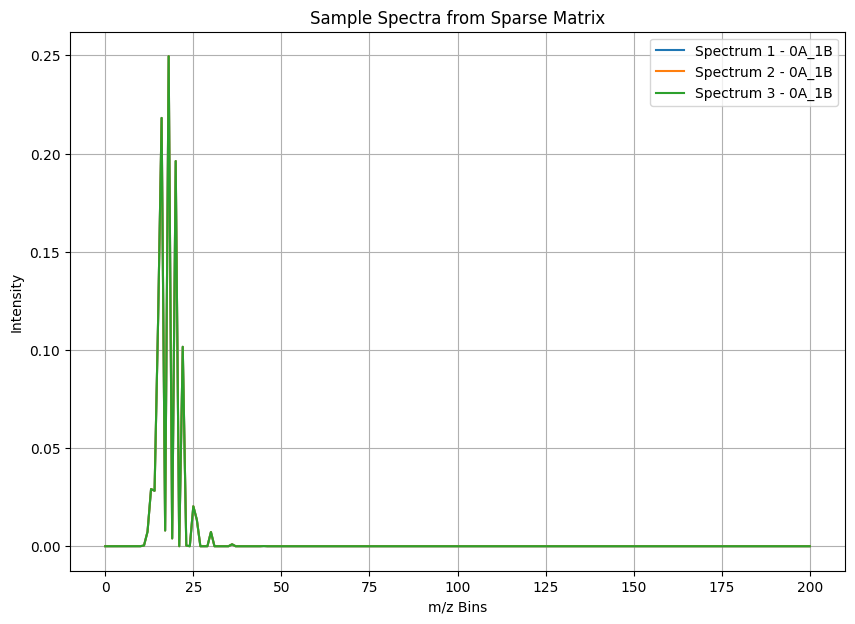

In [152]:
import numpy as np
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

# Load the sparse matrix and labels
sparse_matrix = load_npz("sparse_matrix.npz")
labels = np.load("labels.npy")

# Function to plot a specified number of spectra
def plot_spectra(sparse_matrix, labels, num_spectra=5):
    plt.figure(figsize=(10, 7))
    
    # Ensure we do not try to plot more spectra than we have
    num_spectra = min(num_spectra, sparse_matrix.shape[0])
    
    for i in range(num_spectra):
        # Get the i-th row of the sparse matrix and convert it to a dense format
        spectrum = sparse_matrix.getrow(i).toarray().ravel()
        
        # Plot the spectrum
        plt.plot(spectrum, label=f'Spectrum {i+1} - {labels[i]}')
    
    plt.title('Sample Spectra from Sparse Matrix')
    plt.xlabel('m/z Bins')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot spectra
plot_spectra(sparse_matrix, labels, num_spectra=3)


In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz, load_npz
import json

class NativeMassSpecSimulator:
    def __init__(self, monomer_masses, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
        self.monomer_masses = monomer_masses
        self.resolution = resolution
        self.chargewidth = chargewidth
        self.maxcharge = maxcharge
        self.noise_level = noise_level
        self.Q = Q
        self.F = F
        self.AO = AO
        self.VA = VA
        self.run_counter = 0  # Initialize run counter

    def simulate_complex_spectrum(self, complex_mass):
        mz_range = np.arange(1, 20001)
        spectrum = np.zeros_like(mz_range, dtype=float)

        MS = complex_mass
        MA = self.Q * MS**0.76
        ME = MS + MA
        ZA = 0.0467 * ME**0.533 + self.F
        TT = np.exp(-(np.arange(self.maxcharge) - 50)**2 / self.chargewidth)
        sumT = np.sum(TT)
        WC = np.zeros(self.maxcharge)
        DE = np.zeros_like(WC)

        for charge in range(self.maxcharge):
            WC[charge] = np.exp(-(charge + 1 - ZA)**2 / self.chargewidth) / sumT
            DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * self.AO * self.VA if ME > 0 else 0

        WD = WC * DE

        for charge in range(1, self.maxcharge + 1):
            mz = ME / charge
            if mz < len(mz_range):
                lower_limit = max(1, int(mz - self.resolution / 10))
                upper_limit = min(len(mz_range), int(mz + self.resolution / 10))
                for axis in range(lower_limit, upper_limit):
                    spread = np.exp(-((axis - mz)**2) / (2 * (self.resolution / 100)**2))
                    spectrum[axis] += WD[charge - 1] * spread

        noise = np.random.normal(0, self.noise_level, size=spectrum.size)
        spectrum += noise

        return spectrum
    
    def simulate_mass_spectrum(self, interaction_matrix):
        mz_range = np.arange(1, 20001)
        combined_spectrum = np.zeros_like(mz_range, dtype=float)
        peak_labels = []

        for i, j in np.argwhere(interaction_matrix > 0):

            if i == 0 and j == 0:
                continue   # skip 0,0 as it is absence of both proteins.
            stoich_A = i   # Stoichiometry of Protein A, adjusted for biological indexing
            stoich_B = j   # Stoichiometry of Protein B, adjusted for biological indexing

            complex_mass = stoich_A * self.monomer_masses[0] + stoich_B * self.monomer_masses[1]
            spectrum = self.simulate_complex_spectrum(complex_mass)

            # Scale the spectrum by the interaction matrix value
            scaled_spectrum = spectrum * interaction_matrix[i, j]

            # Generate the peak label based on stoichiometry
            peak_label = f"{stoich_A +1}A_{stoich_B +1}B_{interaction_matrix[i, j]}"
            peak_labels.append(peak_label)

            combined_spectrum += scaled_spectrum
            
        # Normalize the combined spectrum after summing contributions from all interactions
        total_intensity = np.sum(combined_spectrum)
        normalized_spectrum = combined_spectrum / total_intensity if total_intensity > 0 else combined_spectrum

        print("normalized_spectrum:", normalized_spectrum)
        print("peak_labels:", peak_labels)
        
        return mz_range, normalized_spectrum, peak_labels


    def create_interaction_matrix(self, n_proteins):
        interaction_matrix = np.random.randint(0, 2, (n_proteins, n_proteins))
        interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
        return interaction_matrix
    
    def update_interaction_matrix(self, interaction_matrix):
        # Randomly update non-zero values in the interaction matrix
        interaction_matrix = np.where(interaction_matrix > 0, np.random.randint(1, 7, interaction_matrix.shape), interaction_matrix)
        print("updated interaction matrix:", interaction_matrix)

        return interaction_matrix

    def generate_spectra(self, n_proteins, num_spectra):
        spectra_data = []
        label_mapping = {}

        interaction_matrix = self.create_interaction_matrix(n_proteins)

        for i in range(num_spectra):
            if self.run_counter % 5 == 0:
                interaction_matrix = self.update_interaction_matrix(interaction_matrix)
                label_mapping = {}  # Reset the label mapping after updating the interaction matrix

            mz_range, normalized_spectrum, peak_labels = self.simulate_mass_spectrum(interaction_matrix)

            # Bin the m/z values and store the intensity values
            binned_spectrum = []
            for mz, intensity in zip(mz_range, normalized_spectrum):
                bin_idx = int(mz // 100)  # Bin size of 100 m/z units
                binned_spectrum.append((bin_idx, intensity))

            # Update the label mapping
            for label in peak_labels:
                if label not in label_mapping:
                    label_mapping[label] = len(label_mapping)

            print("counter:", self.run_counter)
            self.run_counter += 1  # Increment run counter after each simulation

            spectra_data.append((binned_spectrum, peak_labels))

        return spectra_data, label_mapping


In [245]:

simulator = NativeMassSpecSimulator(
    monomer_masses=[210000, 18000],
    resolution=1000,
    chargewidth=10,
    maxcharge=50,
    noise_level=0.000,
    Q=0.1,
    F=1,
    AO=1,
    VA=1
)

# Generate the interaction matrix - only gen one matrix- is this right? 
n_proteins = 6  # Set the desired number of protein conformations of protein A and B (square)
num_spectra = 100  # Set the desired number of spectra to generate
spectra_data, label_mapping = simulator.generate_spectra(n_proteins, num_spectra)



updated interaction matrix: [[3 0 0 0 0 3]
 [3 5 0 2 4 1]
 [2 0 3 0 0 0]
 [0 0 0 0 0 0]
 [6 0 0 0 2 0]
 [2 0 0 0 6 0]]
normalized_spectrum: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.27962799e-50
 5.49444425e-51 2.32983978e-51]
peak_labels: ['1A_6B_3', '2A_1B_3', '2A_2B_5', '2A_4B_2', '2A_5B_4', '2A_6B_1', '3A_1B_2', '3A_3B_3', '5A_1B_6', '5A_5B_2', '6A_1B_2', '6A_5B_6']
counter: 0
normalized_spectrum: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.27962799e-50
 5.49444425e-51 2.32983978e-51]
peak_labels: ['1A_6B_3', '2A_1B_3', '2A_2B_5', '2A_4B_2', '2A_5B_4', '2A_6B_1', '3A_1B_2', '3A_3B_3', '5A_1B_6', '5A_5B_2', '6A_1B_2', '6A_5B_6']
counter: 1
normalized_spectrum: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.27962799e-50
 5.49444425e-51 2.32983978e-51]
peak_labels: ['1A_6B_3', '2A_1B_3', '2A_2B_5', '2A_4B_2', '2A_5B_4', '2A_6B_1', '3A_1B_2', '3A_3B_3', '5A_1B_6', '5A_5B_2', '6A_1B_2', '6A_5B_6']
counter: 2
normalized_spectrum: [0.00000000e+00 0.00000000e+00 0.00

THere is a mistake in the code where the labels generates are not skipping 0,0 even though i've explicitly said to. The labels are saying 1A,1B for 0,0 ?? on top of this this means the next row is 2 even though that is a monomer row and column. 

Spectrum 1 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B', '2A_6B', '3A_2B', '3A_4B', '3A_6B', '4A_4B', '5A_2B', '6A_4B']
Spectrum 2 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B', '2A_6B', '3A_2B', '3A_4B', '3A_6B', '4A_4B', '5A_2B', '6A_4B']
Spectrum 3 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B', '2A_6B', '3A_2B', '3A_4B', '3A_6B', '4A_4B', '5A_2B', '6A_4B']
Spectrum 4 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B', '2A_6B', '3A_2B', '3A_4B', '3A_6B', '4A_4B', '5A_2B', '6A_4B']
Spectrum 5 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B', '2A_6B', '3A_2B', '3A_4B', '3A_6B', '4A_4B', '5A_2B', '6A_4B']
Spectrum 6 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B', '2A_6B', '3A_2B', '3A_4B', '3A_6B', '4A_4B', '5A_2B', '6A_4B']
Spectrum 7 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B', '2A_6B', '3A_2B', '3A_4B', '3A_6B', '4A_4B', '5A_2B', '6A_4B']
Spectrum 8 peak labels: ['1A_3B', '1A_4B', '1A_6B', '2A_4B', '2A_5B',

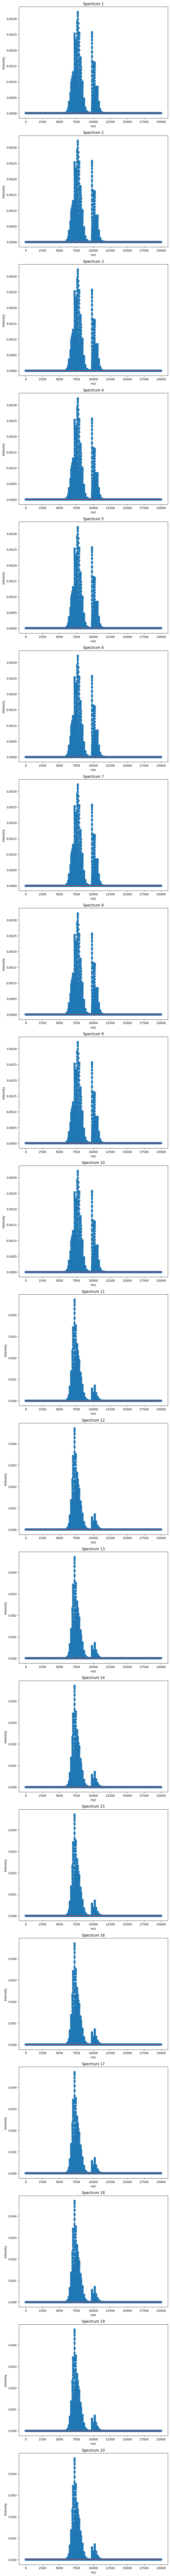

In [236]:
import matplotlib.pyplot as plt

# Plot a few spectra
num_spectra_to_plot = 20  # Adjust this value to plot more or fewer spectra

fig, axs = plt.subplots(num_spectra_to_plot, 1, figsize=(8, 6 * num_spectra_to_plot))

for i in range(num_spectra_to_plot):
    binned_spectrum, peak_labels = spectra_data[i]
    mz_values = [100 * mz for mz, _ in binned_spectrum]
    intensities = [intensity for _, intensity in binned_spectrum]

    print(f"Spectrum {i+1} peak labels: {peak_labels}")


    if num_spectra_to_plot == 1:
        ax = axs
    else:
        ax = axs[i]

    ax.stem(mz_values, intensities)
    ax.set_xlabel('m/z')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Spectrum {i+1}')

plt.tight_layout()
plt.show()

In [225]:
import numpy as np
from scipy.sparse import csr_matrix, save_npz
import json

data = []
row_indices = []
col_indices = []
labels = []

# Process each spectrum to collect intensity data and labels
for spectrum_idx, (spectrum, peak_labels) in enumerate(spectra_data):
    # Collect data for the sparse matrix
    for bin_idx, intensity in spectrum:
        data.append(intensity)
        row_indices.append(spectrum_idx)
        col_indices.append(bin_idx)

    # Concatenate the peak labels for the current spectrum
    label_str = ','.join(peak_labels)
    labels.append(label_str)

# Determine the number of bins (the max index + 1 ensures all indices are covered)
num_bins = max(col_indices) + 1 if col_indices else 0

# Create the CSR matrix from the collected data
sparse_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(len(spectra_data), num_bins))

# Save the sparse matrix to an NPZ file
save_npz("sparse_matrix.npz", sparse_matrix)

# Save the labels as a numpy array to maintain the structure
np.save("labels.npy", np.array(labels))

# Save the label mapping to a JSON file for easy lookup and reference
with open("label_mapping.json", "w") as f:
    json.dump(label_mapping, f)


In [226]:
import numpy as np
from scipy.sparse import load_npz

# Load the sparse matrix from the NPZ file
sparse_matrix = load_npz("sparse_matrix.npz")

# Print the shape of the matrix to understand its dimensions
print("Shape of sparse matrix:", sparse_matrix.shape)

# Convert the sparse matrix to a dense format and print a small portion to see its content
print("Contents of sparse matrix (small portion):")
print(sparse_matrix.toarray()[20:50])  # Adjust the slice as necessary to limit output


Shape of sparse matrix: (100, 201)
Contents of sparse matrix (small portion):
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.13592112e-29
  3.96021015e-31 8.99818018e-35]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.13592112e-29
  3.96021015e-31 8.99818018e-35]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.13592112e-29
  3.96021015e-31 8.99818018e-35]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25779016e-29
  6.16952213e-32 4.34728244e-35]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25779016e-29
  6.16952213e-32 4.34728244e-35]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25779016e-29
  6.16952213e-32 4.34728244e-35]]


In [227]:
# Load the labels from the numpy file
labels = np.load("labels.npy")

# Print the first few labels to see how they are structured
print("First few labels:")
print(labels[:20])  # Adjust the number to display more or fewer labels


First few labels:
['1A_1B,1A_3B,1A_4B,1A_5B,1A_7B,1A_9B,2A_1B,2A_2B,2A_3B,2A_4B,2A_5B,2A_7B,2A_8B,2A_9B,3A_1B,3A_3B,3A_5B,3A_6B,3A_8B,3A_9B,4A_3B,4A_5B,4A_6B,4A_7B,4A_10B,5A_1B,5A_2B,5A_4B,5A_5B,5A_7B,5A_10B,6A_4B,6A_5B,6A_6B,6A_7B,6A_9B,6A_10B,7A_2B,7A_6B,7A_7B,7A_9B,8A_1B,8A_2B,9A_2B,9A_10B,10A_1B,10A_2B,10A_3B,10A_5B,10A_6B,10A_9B'
 '1A_1B,1A_3B,1A_4B,1A_5B,1A_7B,1A_9B,2A_1B,2A_2B,2A_3B,2A_4B,2A_5B,2A_7B,2A_8B,2A_9B,3A_1B,3A_3B,3A_5B,3A_6B,3A_8B,3A_9B,4A_3B,4A_5B,4A_6B,4A_7B,4A_10B,5A_1B,5A_2B,5A_4B,5A_5B,5A_7B,5A_10B,6A_4B,6A_5B,6A_6B,6A_7B,6A_9B,6A_10B,7A_2B,7A_6B,7A_7B,7A_9B,8A_1B,8A_2B,9A_2B,9A_10B,10A_1B,10A_2B,10A_3B,10A_5B,10A_6B,10A_9B'
 '1A_1B,1A_3B,1A_4B,1A_5B,1A_7B,1A_9B,2A_1B,2A_2B,2A_3B,2A_4B,2A_5B,2A_7B,2A_8B,2A_9B,3A_1B,3A_3B,3A_5B,3A_6B,3A_8B,3A_9B,4A_3B,4A_5B,4A_6B,4A_7B,4A_10B,5A_1B,5A_2B,5A_4B,5A_5B,5A_7B,5A_10B,6A_4B,6A_5B,6A_6B,6A_7B,6A_9B,6A_10B,7A_2B,7A_6B,7A_7B,7A_9B,8A_1B,8A_2B,9A_2B,9A_10B,10A_1B,10A_2B,10A_3B,10A_5B,10A_6B,10A_9B'
 '1A_1B,1A_3B,1A_4B,1A_5B

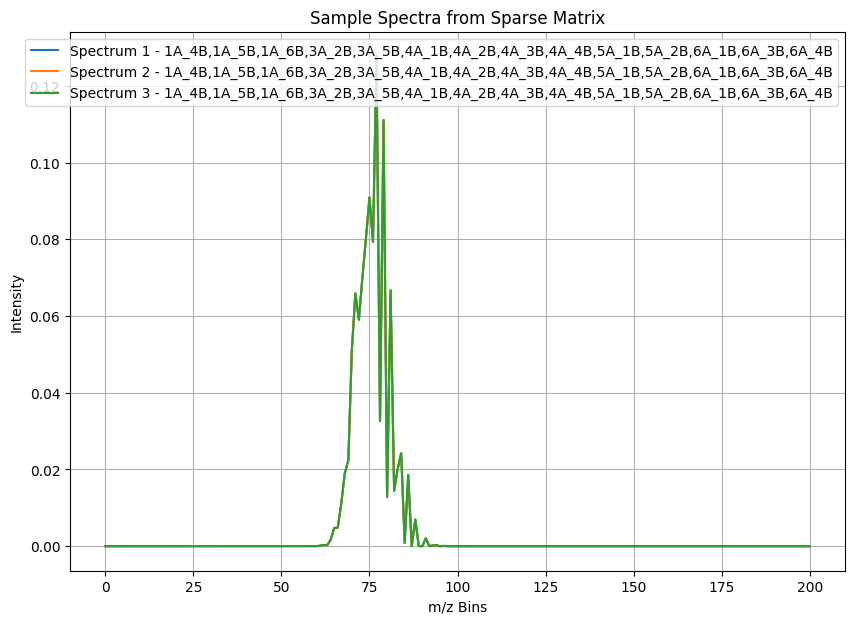

In [180]:
import numpy as np
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

# Load the sparse matrix and labels
sparse_matrix = load_npz("sparse_matrix.npz")
labels = np.load("labels.npy")

# Function to plot a specified number of spectra
def plot_spectra(sparse_matrix, labels, num_spectra=5):
    plt.figure(figsize=(10, 7))
    
    # Ensure we do not try to plot more spectra than we have
    num_spectra = min(num_spectra, sparse_matrix.shape[0])
    
    for i in range(num_spectra):
        # Get the i-th row of the sparse matrix and convert it to a dense format
        spectrum = sparse_matrix.getrow(i).toarray().ravel()
        
        # Plot the spectrum
        plt.plot(spectrum, label=f'Spectrum {i+1} - {labels[i]}')
    
    plt.title('Sample Spectra from Sparse Matrix')
    plt.xlabel('m/z Bins')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot spectra
plot_spectra(sparse_matrix, labels, num_spectra=3)
